# Updated proto-clustering process

1) Transfer preparation from R to python

2) Update process with 2019 data

3) Normalise numeric variables

4) Probabilistic scaling of population by weights

5) Perform proto-clustering (possibly with random 10% sample) 

6) Predict clusters from 2015 data

In [1]:
%autosave 180

Autosaving every 180 seconds


In [97]:
#Load packages
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes

In [3]:
pwd

'/Users/tjark/Documents/Python/clustering.nosync/cluster process'

In [4]:
os.chdir("..")

In [ ]:
# Downloaded data for area A - Ile de France
# https://www.insee.fr/fr/statistiques/6544333?sommaire=6456104

In [5]:
census = pd.read_csv('data/raw/FD_INDCVIZA_2019.csv', sep = ';') 

/var/folders/93/smcvnv_s04v84f_dnqvd4xkw0000gn/T/ipykernel_3019/2176412577.py:1: DtypeWarning: Columns (0,1,2,3,9,10,11,12,16,19,22,29,35,36,42,43,47,48,49,50,57,63,68,71,74,75,80,81,83,84,85,86) have mixed types. Specify dtype option on import or set low_memory=False.
  census = pd.read_csv('data/raw/FD_INDCVIZA_2019.csv', sep = ';')


In [6]:
census.head()

,CANTVILLE,NUMMI,ACHLR,AEMMR,AGED,AGER20,AGEREV,AGEREVQ,ANAI,ANEMR,...,TP,TRANS,TRIRIS,TYPC,TYPFC,TYPL,TYPMC,TYPMR,VOIT,WC
0,75ZZ,1,1,9,72,79,72,70,1944,2,...,Z,Z,751501,3,Z,1,1,12,1,Z
1,75ZZ,2,2,9,59,64,58,55,1958,3,...,1,5,750901,3,2,6,4,41,0,Z
2,75ZZ,2,2,9,30,29,29,25,1987,3,...,1,6,750901,3,2,6,4,41,0,Z
3,75ZZ,3,1,7,82,80,81,80,1938,5,...,Z,Z,751431,3,2,2,4,44,1,Z
4,75ZZ,3,1,7,86,80,85,85,1934,5,...,Z,Z,751431,3,2,2,4,44,1,Z


In [7]:
#drop columns that aren't used
census = census.drop(labels=['ACHLR','AEMMR','AGER20','AGEREV','AGEREVQ','ANAI','ANEMR',
            'APAF','ARM','ASCEN','BAIN','BATI','CANTVILLE','CATIRIS','CATL','CATPC','CHAU',
            'CHFL','CHOS','CLIM','CMBL','CUIS','DEPT','DEROU','DNAI','EAU','EGOUL','ELEC','EMPL',
            'HLML','INATC','INFAM','INPER','INPERF','IRAN','LIENF','LPRF','LPRM','METRODOM','NA5','NAIDT',
            'NE24FR','NE3FR','NENFR','NUMF','NUMMI','ORIDT','RECH',
            'REGION','SANI','SANIDOM','SFM','TACTD16','TRIRIS','TYPC',
            'TYPFC','TYPMC','TYPMR','WC'], axis=1)

In [9]:
list(census.columns.values.tolist())

['AGED',
 'COUPLE',
 'CS1',
 'DIPL',
 'ETUD',
 'GARL',
 'ILETUD',
 'ILT',
 'IMMI',
 'INAI',
 'IPONDI',
 'IRIS',
 'MOCO',
 'MODV',
 'NA17',
 'NBPI',
 'NE17FR',
 'NE5FR',
 'NPERR',
 'SEXE',
 'STAT_CONJ',
 'STATR',
 'STOCD',
 'SURF',
 'TACT',
 'TP',
 'TRANS',
 'TYPL',
 'VOIT']

In [11]:
census4cluster = census.drop(labels=['AGED','IRIS','NE17FR'], axis=1)

## Convert weights 'IPONDI' to integrer multiplicators via stochastic rounding 

In [12]:
census4cluster['intweight'] = census4cluster['IPONDI'].astype(int)

In [13]:
census4cluster['fractweight'] = census4cluster['IPONDI'] - census4cluster['intweight']

In [14]:
u = random.random()
census4cluster['multiplicator'] = census4cluster['intweight'] + (u < census4cluster['fractweight'])

In [15]:
# delete columns no longer needed
census4cluster = census4cluster.drop(labels=['intweight','fractweight','IPONDI'], axis=1)

# Clustering process

## Normalisation of numeric variables NBPI, NE5FR, NPERR, VOIT

In [16]:
# Convert non numeric values to NA
census4cluster['NBPI'] = pd.to_numeric(census4cluster['NBPI'], errors='coerce')
census4cluster['NE5FR'] = pd.to_numeric(census4cluster['NE5FR'], errors='coerce')
census4cluster['NPERR'] = pd.to_numeric(census4cluster['NPERR'], errors='coerce')
census4cluster['VOIT'] = pd.to_numeric(census4cluster['VOIT'], errors='coerce')

In [17]:
# Calculate normalised values
census4cluster['NBPI'] = (census4cluster['NBPI'] - census4cluster['NBPI'].min()) / (census4cluster['NBPI'].max() - census4cluster['NBPI'].min())
census4cluster['NE5FR'] = (census4cluster['NE5FR'] - census4cluster['NE5FR'].min()) / (census4cluster['NE5FR'].max() - census4cluster['NE5FR'].min())
census4cluster['NPERR'] = (census4cluster['NPERR'] - census4cluster['NPERR'].min()) / (census4cluster['NPERR'].max() - census4cluster['NPERR'].min())
census4cluster['VOIT'] = (census4cluster['VOIT'] - census4cluster['VOIT'].min()) / (census4cluster['VOIT'].max() - census4cluster['VOIT'].min())

In [18]:
# Replace NA with mean values
census4cluster['NBPI'].fillna(census4cluster['NBPI'].mean(), inplace=True)
census4cluster['NE5FR'].fillna(census4cluster['NE5FR'].mean(), inplace=True)
census4cluster['NPERR'].fillna(census4cluster['NPERR'].mean(), inplace=True)
census4cluster['VOIT'].fillna(census4cluster['VOIT'].mean(), inplace=True)

## Prepare data

In [19]:
# Encoding ordinal variable SURF
census4cluster['SURF'] = census4cluster['SURF'].astype(str)
categories = sorted(census4cluster['SURF'].unique())
census4cluster['SURF'] = pd.Categorical(census4cluster['SURF'], categories=categories, ordered=True)

In [20]:
census4cluster.head()

,COUPLE,CS1,DIPL,ETUD,GARL,ILETUD,ILT,IMMI,INAI,MOCO,...,STAT_CONJ,STATR,STOCD,SURF,TACT,TP,TRANS,TYPL,VOIT,multiplicator
0,2,7,19,2,1,Z,Z,2,3,32,...,6,Z,10,4,21,Z,Z,1,0.333333,4
1,1,3,17,2,2,Z,1,1,6,21,...,3,2,21,1,11,1,5,6,0.000000,4
2,1,3,16,2,2,Z,3,1,6,21,...,3,2,21,1,11,1,6,6,0.000000,4
3,1,7,14,2,1,Z,Z,2,2,21,...,1,Z,10,4,21,Z,Z,2,0.333333,4
4,1,7,14,2,1,Z,Z,2,1,21,...,1,Z,10,4,21,Z,Z,2,0.333333,4


In [22]:
# Encoding nominal variables
NomVariables = ['COUPLE','CS1','DIPL','ETUD','GARL','ILETUD','ILT','IMMI','INAI','MOCO',
                'MODV','NA17','SEXE','STAT_CONJ','STATR','STOCD','TACT','TP','TRANS','TYPL']

# Iterate through the list using a for loop
for NomVar in NomVariables:
    census4cluster[NomVar] = census4cluster[NomVar].astype(str)
    categories = sorted(census4cluster[NomVar].unique())
    census4cluster[NomVar] = pd.Categorical(census4cluster[NomVar], categories=categories, ordered=False)

## Scale populations by multiplicator

In [23]:
census4cluster.insert(0, 'ID', range(0, len(census4cluster)))

In [24]:
def scale_rows(df_group):
    # calculate the number of times to repeat each row
    weight = df_group['multiplicator'].iloc[0]
    # repeat each row based on the weight column
    df_group = df_group.iloc[np.repeat(np.arange(len(df_group)), weight)]
    return df_group

In [29]:
#create sample for efficiency
sample_census4cluster = census4cluster.sample(n=1000)

In [30]:
# apply the scaling function to each group of rows with the same ID
census4cluster_scaled = sample_census4cluster.groupby('ID').apply(scale_rows)
# reset the index of the new dataframe
census4cluster_scaled.reset_index(drop=True, inplace=True)
# delete ID and multiplocator columns no longer needed
census4cluster_scaled = census4cluster_scaled.drop(labels=['multiplicator','ID'], axis=1)

## Elbow test

In [47]:
K = [list(range(2,6))]


In [56]:
census4cluster_scaled.head()

,COUPLE,CS1,DIPL,ETUD,GARL,ILETUD,ILT,IMMI,INAI,MOCO,...,SEXE,STAT_CONJ,STATR,STOCD,SURF,TACT,TP,TRANS,TYPL,VOIT
0,2,4,17,2,2,Z,1,2,3,31,...,2,6,1,21,3,11,1,6,2,0.0
1,2,4,17,2,2,Z,1,2,3,31,...,2,6,1,21,3,11,1,6,2,0.0
2,2,4,17,2,2,Z,1,2,3,31,...,2,6,1,21,3,11,1,6,2,0.0
3,1,3,18,1,2,3,1,2,4,32,...,1,3,1,10,1,11,2,6,2,0.0
4,1,3,18,1,2,3,1,2,4,32,...,1,3,1,10,1,11,2,6,2,0.0


In [142]:
# define min and max number of clusters
min_clust = 2
max_clust = 50
k_range = list(range(min_clust,max_clust+1,2))
# empty array for within of Within-cluster sum of squares WCSS
wcss = []

#verbose 0 = no process output, 1 = clusters per entry, 2 = full messages

for k in k_range:
    kproto = KPrototypes(n_clusters=k, init='Cao', verbose=0)
    clusters = kproto.fit_predict(census4cluster_scaled,categorical=[0,1,2,3,4,5,6,7,8,9,10,11,15,16,17,18,19,20,21,22,23])
    
    wcss.append(kproto.cost_)

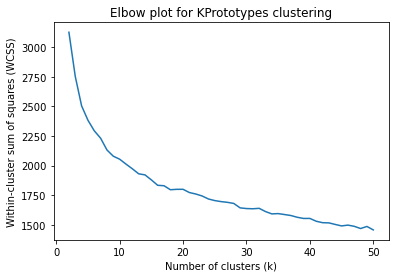

In [143]:
# plot the WCSS against k
plt.plot(k_range, wcss)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster sum of squares (WCSS)')
plt.title('Elbow plot for KPrototypes clustering')
plt.show()

In [153]:
wcss_file = pd.DataFrame (wcss, columns = ['wcss'])

In [154]:
wcss_file.to_csv('data/interim/wcss.csv')

## Final clustering

In [ ]:
# apply the scaling function to each group of rows with the same ID
census4cluster_scaled = census4cluster.groupby('ID').apply(scale_rows)
# reset the index of the new dataframe
census4cluster_scaled.reset_index(drop=True, inplace=True)
# delete ID and multiplocator columns no longer needed
census4cluster_scaled = census4cluster_scaled.drop(labels=['multiplicator','ID'], axis=1)

In [ ]:
#define number of clusters
k = 16

kproto = KPrototypes(n_clusters=k, init='Cao', verbose=0)
clusters = kproto.fit_predict(census4cluster_scaled,categorical=[0,1,2,3,4,5,6,7,8,9,10,11,15,16,17,18,19,20,21,22,23])

In [ ]:
# Add cluster IDs to initial file
census4cluster_scaled['cluster'] = clusters